In [1]:
import numpy as np
import os
import matplotlib.image as mpimmg
import pandas as pd
import tensorflow as tf
import cv2
from glob import glob

In [2]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical  # Corrected import
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split


In [3]:
import warnings 
warnings.filterwarnings('ignore')

In [4]:
# Extracting the compressed dataset. 
from zipfile import ZipFile

data_path = 'Traffic signs.zip'

#Open the zipfile in read mode and extract all the contents 
with ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
#Path to the dataset containing the dataset
dataset = 'Traffic signs.zip'

#path of label file
labelfile = pd.read_csv('labels.csv')

In [6]:
import os

data_path = 'Traffic signs.zip'
extraction_path = 'extracted_data'  # Define where to extract the files

# Create the directory if it doesn't exist
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

# Extract the ZIP file
with ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)


In [7]:
# List files in the extraction directory
extracted_files = os.listdir(extraction_path)
print("Files in the extracted directory:", extracted_files)


Files in the extracted directory: ['labels.csv', 'traffic_Data']


In [8]:
# Example: Find a specific image file
image_name = '010_0011.png'
image_path = None

for root, dirs, files in os.walk(extraction_path):
    if image_name in files:
        image_path = os.path.join(root, image_name)
        break

if image_path:
    print("Image path found:", image_path)
else:
    print("Image not found.")



Image path found: extracted_data\traffic_Data\DATA\10\010_0011.png


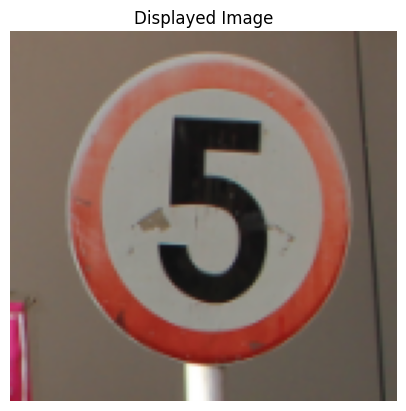

In [9]:
import cv2
import matplotlib.pyplot as plt 

image_path = "extracted_data/traffic_Data/DATA/0/000_1_0001.png" 

# Read the image using OpenCV
img = cv2.imread(image_path)

# Check if the image was loaded correctly
if img is not None:
    # Convert from OpenCV's default BGR format to RGB format for Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Use Matplotlib to display the image
    plt.imshow(img_rgb)
    plt.title('Displayed Image')
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()
else:
    print("The image path is incorrect or the image file cannot be read.")


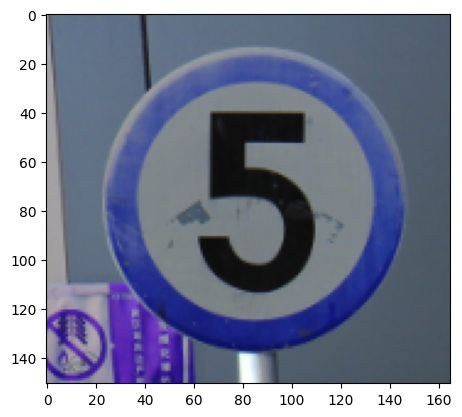

In [10]:
img = cv2.imread("extracted_data/traffic_Data/DATA/0/000_1_0002.png") 
plt.imshow(img) 

In [11]:
labelfile.head() # head of table

ClassId                  Name
0        0   Speed limit (5km/h)
1        1  Speed limit (15km/h)
2        2  Speed limit (30km/h)
3        3  Speed limit (40km/h)
4        4  Speed limit (50km/h)

In [12]:
#Tail part of the table
labelfile.tail()

ClassId         Name
53       53     Give Way
54       54  No stopping
55       55     No entry
56       56     Unknown7
57       57     Unknown8

### Data prepration for training

In [13]:
dataset = 'extracted_data/traffic_Data/DATA'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset, validation_split=0.2, subset='training', image_size=(224, 224), seed=123, batch_size= 32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset, validation_split=0.2, subset='validation', image_size=(224, 224), seed=123, batch_size=32)

Found 4170 files belonging to 58 classes.
Using 3336 files for training.
Found 4170 files belonging to 58 classes.
Using 834 files for validation.


In [14]:
#Create some list of classes and print few images along with their class names.
class_numbers = train_ds.class_names
class_names = []
for i in class_numbers:
    class_names.append(labelfile['Name'][int(i)])

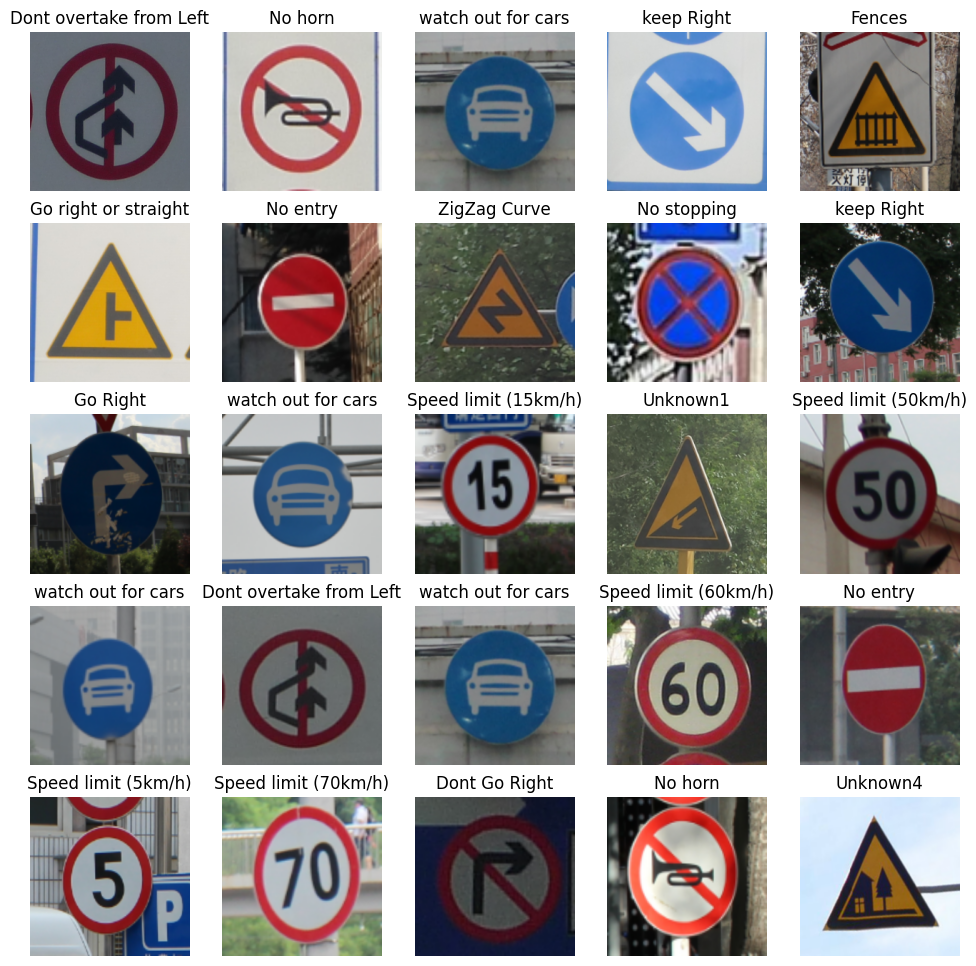

In [15]:
#Visualize the images of the training dataset
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

plt.show()

### Data Augmentation

In [16]:
data_augmentation = tf.keras.Sequential( 
    [ 
        tf.keras.layers.experimental.preprocessing.RandomFlip( 
            "horizontal", input_shape=(224, 224, 3)), 
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1), 
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2), 
        tf.keras.layers.experimental.preprocessing.RandomFlip( 
            mode="horizontal_and_vertical") 
    ] 
) 

In [17]:
#Model Architecture 

model = Sequential() 
model.add(data_augmentation) 
model.add(Rescaling(1./255)) 
model.add(Conv2D(128, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2))) 
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2))) 
model.add(Conv2D(128, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2))) 
model.add(Conv2D(256, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2))) 
model.add(Flatten()) 
model.add(Dense(64, activation='relu')) 
model.add(Dropout(0.2)) 
model.add(Dense(128, activation='relu')) 
model.add(Dense(len(labelfile), activation='softmax')) 

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                 

In [23]:
from tensorflow.keras.utils import plot_model

# To visualize the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_dtype=True, show_layer_activations=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy']) 

### Model Training 

In [25]:

# Set callback functions to early stop training 
mycallbacks = [EarlyStopping(monitor='val_loss', patience=5)] 
history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=mycallbacks) 

Epoch 1/50


105/105 [==============================] - 1569s 15s/step - loss: 3.2038 - accuracy: 0.1829 - val_loss: 2.3675 - val_accuracy: 0.3561
Epoch 2/50
105/105 [==============================] - 1555s 15s/step - loss: 2.2881 - accuracy: 0.3393 - val_loss: 1.9197 - val_accuracy: 0.4149
Epoch 3/50
105/105 [==============================] - 1489s 14s/step - loss: 1.9141 - accuracy: 0.4029 - val_loss: 1.5901 - val_accuracy: 0.4808
Epoch 4/50
105/105 [==============================] - 1489s 14s/step - loss: 1.6831 - accuracy: 0.4559 - val_loss: 1.4131 - val_accuracy: 0.5887
Epoch 5/50
105/105 [==============================] - 1514s 14s/step - loss: 1.5047 - accuracy: 0.5051 - val_loss: 1.2955 - val_accuracy: 0.5851
Epoch 6/50
105/105 [==============================] - 1507s 14s/step - loss: 1.4408 - accuracy: 0.5219 - val_loss: 1.1224 - val_accuracy: 0.6379
Epoch 7/50
105/105 [==============================] - 1495s 14s/step - loss: 1.3733 - accuracy: 0.5555 - val_loss: 1.0256 - val_

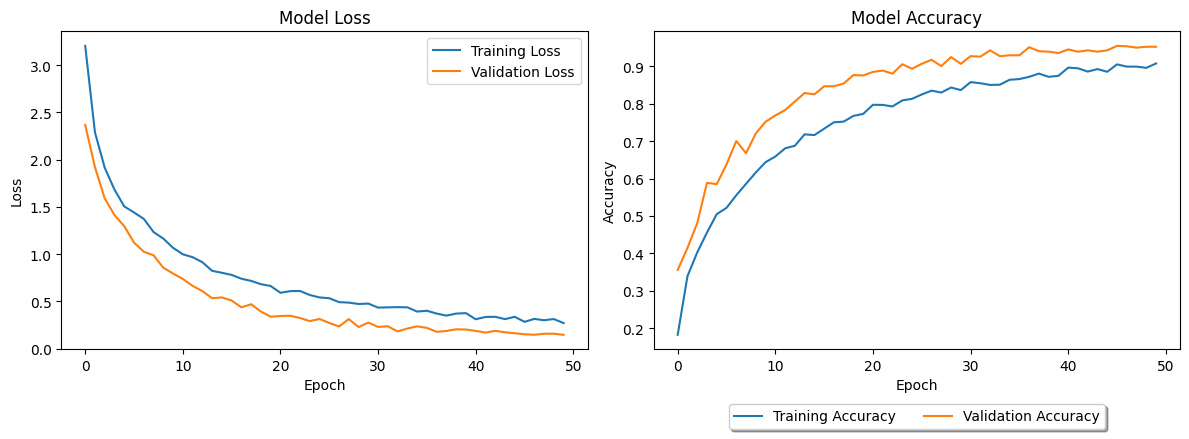

In [29]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))  # Adjust the size to better fit both subplots

# 1st subplot for Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# 2nd subplot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# Place legend at the bottom of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()


In [41]:
# Define the path where you want to save your model
model_path = r'C:\Users\User\Documents\MY PROJECTS\CODES\Traffic sign detection\trained_model.h5'

# Save the model
model.save(model_path)


In [42]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model(model_path)

# Optionally, use the loaded model for predictions to verify everything is in order
# predictions = loaded_model.predict(your_test_data_here)


In [45]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image using OpenCV
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found")

    # Convert the image from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to match the model's expected input dimensions
    img = cv2.resize(img, target_size)

    # Normalize pixel values to [0, 1]
    img = img.astype('float32') / 255.0

    # Add a batch dimension
    img = np.expand_dims(img, axis=0)
    return img

# Path to the single image
image_path = 'Traffic sign image.jpg'  # Update this to the path where you saved the image

# Preprocess the image
preprocessed_image = load_and_preprocess_image(image_path)

# Assuming your model is loaded
model = load_model('trained_model.h5')  # Make sure the path is correct

# Predict using the model
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions, axis=1) 
print("Predicted class index:", predicted_class)


1/1 [==============================] - 0s 226ms/step
Predicted class index: [[[151  98 222 151]
  [ 74  99 138 151]
  [ 74  77 141 151]
  [ 74  18 147 151]
  [ 74  18 213 151]
  [ 74  18 142 151]
  [ 74  18 223 151]
  [ 74  18 175 151]
  [151  18 144  74]
  [151  14  13  74]
  [151  14  33  74]
  [151  48  22 164]
  [151  16 139  81]
  [ 74  51 154  81]
  [ 74  51 220 166]
  [ 74 149 162  89]
  [ 74 131  93  91]
  [ 74 118  88  91]
  [ 74 121  94  88]
  [ 74 118  94  92]
  [156 131 101  89]
  [156  76  93  90]
  [156  78 105 161]
  [ 74  76  94 200]
  [117  63  90 104]
  [ 74  63  87 158]
  [116 120  16  92]
  [176   4 103 164]
  [116  49  21 165]
  [ 74  51  19 168]
  [ 83  51  18  51]
  [ 85  50  17  50]
  [158  47  18  48]
  [ 64  47  19  47]
  [ 95  46  19  47]
  [163  47  16  53]
  [ 74  47  20  48]
  [160  47  19  49]
  [ 74  51  19  51]
  [ 95  50  17  50]
  [ 74  50  10 161]
  [ 74  52  12  93]
  [ 38  50  10 168]
  [ 36  49  19  92]
  [ 41  48  14 166]
  [ 39  47  13  91]
  [ 

In [50]:
class_probabilities = np.random.rand(224, 4)  # Random probabilities for demonstration

# Find the box with the highest confidence of being a traffic sign 
max_prob_index = np.argmax(class_probabilities)  # Index of the highest probability
predicted_box = predicted_class[0][max_prob_index]  # Get the corresponding bounding box

print("Predicted bounding box:", predicted_box)


Predicted bounding box: [151   3 186  74]


In [53]:
from tensorflow.keras.models import load_model

# Load your pre-trained model
model = load_model('trained_model.h5')

# Predict on the loaded images
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)  # Assuming a classification task

# Optionally print or save the prediction results
for filename, pred_class in zip(filenames, predicted_classes):
    print(f"Image: {filename} - Predicted Class: {pred_class}")


28/28 [==============================] - 9s 299ms/step
Image: road0.png - Predicted Class: [[152 161 155   0]
 [156 161 154   0]
 [177   0 155  17]
 [163 189 187  15]
 [187 190 155 187]
 [186  13 157 187]
 [186 184 155 187]
 [186  18 155 187]
 [187 190 155 187]
 [152 187 203 138]
 [138 184 186 138]
 [163 165 185 127]
 [185 139 185 128]
 [163 123 184 128]
 [163 120 154 133]
 [140 120 171 133]
 [136 129 154 133]
 [136 109 184 133]
 [162 110 184 136]
 [162 108 184 136]
 [162  64 183 135]
 [164 108 170 142]
 [162 111 186 145]
 [162 113 186 144]
 [162 105 186 145]
 [162 105 189 145]
 [164 111 189 145]
 [187  99 188 147]
 [164  99 188 147]
 [164  99 188 147]
 [164  99 188 147]
 [164 100 189 145]
 [192  98 189 148]
 [192  96 189 192]
 [192  96 189 192]
 [192  96 189 192]
 [161 179 195 161]
 [161  99 196 161]
 [179 100 196 161]
 [179 100 196 147]
 [179  96 196 149]
 [192  90 197 192]
 [192  90 196 192]
 [192  96 186 192]
 [192  96 186 192]
 [184  96 186 147]
 [184  96 186 143]
 [143  97 185 14

In [55]:
print("Predicted classes:", predicted_classes)
print("Predicted classes type:", type(predicted_classes[0]))
print("Shape of predicted_classes:", predicted_classes.shape)

Predicted classes: [[[152 161 155   0]
  [156 161 154   0]
  [177   0 155  17]
  ...
  [ 83  72 207  84]
  [ 82  78 207  82]
  [ 84  72 207  84]]

 [[ 84 131 199 122]
  [ 84 129 194  93]
  [ 86 126 193 123]
  ...
  [102 223 141  30]
  [106 187 140  30]
  [105 186 140  29]]

 [[108 186 161  64]
  [108 178 161  78]
  [ 64 175 161  64]
  ...
  [ 82 222 210 155]
  [ 79 220 221  81]
  [ 79 222 222  85]]

 ...

 [[205 139   0 194]
  [205 142   0 195]
  [205 156   0 194]
  ...
  [207 104   0 223]
  [207 103   0 193]
  [207  94   0 183]]

 [[185 149 141   0]
  [185 149 141   0]
  [185 149 142   0]
  ...
  [ 43  37 218  36]
  [ 69  38 218  36]
  [ 69  38 218  36]]

 [[  0 125 111   0]
  [  0 125 142   0]
  [  0 125 125   0]
  ...
  [170 126 223  17]
  [170 126 202  16]
  [170 126 202  16]]]
Predicted classes type: <class 'numpy.ndarray'>
Shape of predicted_classes: (877, 224, 4)


In [56]:
# If pred_class is an array instead of a scalar
if isinstance(predicted_classes[0], np.ndarray):
    predicted_classes = np.array([x[0] for x in predicted_classes])

In [57]:
import matplotlib.pyplot as plt

def display_images_with_predictions(images, predicted_classes, class_names):
    plt.figure(figsize=(12, 12))
    for i, (image, pred_class) in enumerate(zip(images, predicted_classes)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(image)
        if isinstance(pred_class, np.ndarray):
            pred_class = pred_class[0] 
        plt.title(f"Predicted: {class_names[int(pred_class)]}")  
        plt.axis('off')
    plt.tight_layout()
    plt.show()

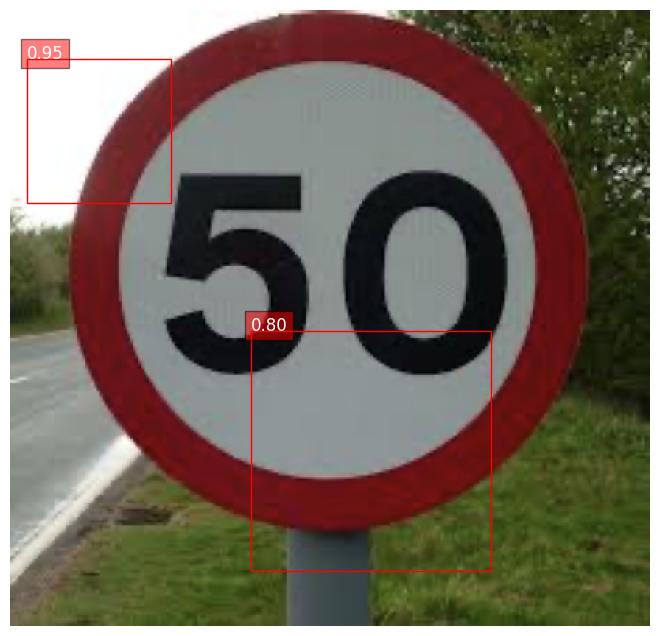

In [73]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes_with_scores(image, boxes, scores):
    # Assuming 'boxes' are [x_min, y_min, x_max, y_max] and 'scores' are confidence scores
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    for box, score in zip(boxes, scores):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'{score:.2f}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    plt.axis('off')
    plt.show()

# Example usage
image_path = 'images/road100.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
boxes = [[10, 30, 100, 120], [150, 200, 300, 350]]  # example boxes
scores = [0.95, 0.80]  # example confidence scores
draw_bounding_boxes_with_scores(image, boxes, scores)
